In [ ]:
#### Final Project Spatial Python ####

## Author: Caroline Busse
## Date: September 2021

## Deep Learning for Patch-based LULC Classification
# using the EuroSAT dataset to train a convolutional neural network to predict LULC classes of a new dataset
# via transfer learning the CNN model is pre-trained on the EuroSAT (labeled 64x64m Sentinel 2 tiles) and then applied to classif the LULC of the city of Leipzig

## Script Structure
# 0. Download EuroSAT data
# 1. Data Exploration of EuroSAT dataset
# 2. Pre-Processing of image tiles
# 3. Model Building
# 4. Accuracy Assessment
# 5. Transfer Learning: apply pre-trained model to new data (unlabeled Sentinel-2 64x64m tiles in city of Leipzig) to predict their LULC class
# 6. Validation of the predicted LULC classes via field data collected in Leipzig
# 7. Research Outcome

## Sources:
#[1] Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.
#[2] Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.

In [43]:
## import libraries

# processing & reading images
from skimage.color import rgb2gray
import rasterio
import numpy as np
import os
import pandas as pd
import glob
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# CNN modeling
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adadelta
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, GlobalAveragePooling2D
from keras import backend as K

# plotting
import earthpy.plot as ep
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imshow, subplots, show
from keras.utils.vis_utils import plot_model
import seaborn as sn

# evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

In [ ]:
#### 0. Data Download ####
## Download the EuroSAT dataset: 
## http://madm.dfki.de/files/sentinel/EuroSATallBands.zip

# first large-scale patch-based LULC classification dataset from Sentinel-2 satellite images (Helber et al 2018)
# 10 LULC classes

In [ ]:
## read in EuroSAT training data

# set directory in which EuroSAT data was downloaded & unzipped into
imgdir = "EuroSATallBands\\ds\\images\\remote_sensing\\otherDatasets\\sentinel_2\\tif"

# list folders in directory (correspond to LULC classes)
labels = os.listdir(imgdir)

imgfiles = [] 

# keep only those files containing ".tif"
for file in glob.glob(imgdir + os.sep + "*" + os.sep + "*.tif"):
  imgfiles.append(file)

In [ ]:
#### 1. Data Exploration ####

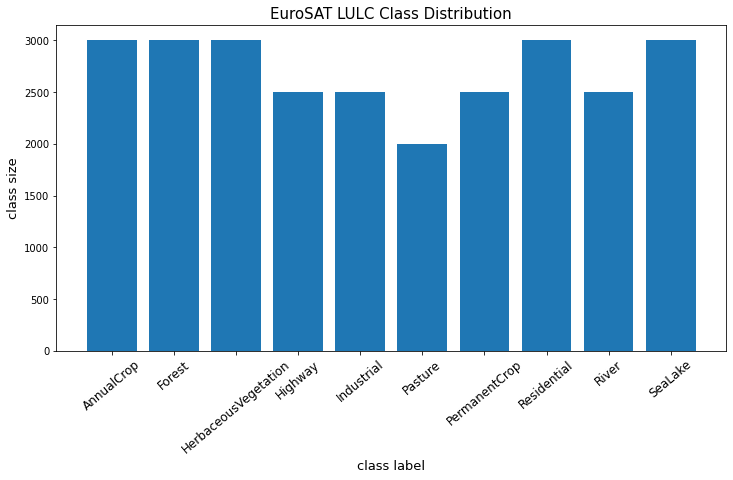

In [11]:
## plot LULC class distribution

counts = {}

# loop over folders & count number of tiles
for l in labels:
    counts[l] = len(os.listdir(os.path.join(imgdir, l)))

plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EuroSAT LULC Class Distribution', fontsize=15);

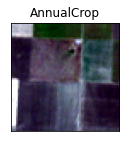

In [12]:
## plot the first image
raster = rasterio.open(imgfiles[0])
img = raster.read((2,3,4,8)) # read all 10m bands

# save folder name (=class) as title
title = imgfiles[0].split('\\')[-2]
fig, ax = plt.subplots(figsize=(2, 2))

# Plot red, green and blue bands
ep.plot_rgb(img, rgb = [2, 1, 0], ax=ax, stretch=True, title = title)
plt.show()

In [ ]:
#### 2. Pre-Processing ####

In [13]:
## normalize bands to reflectance values between 0 and 1
def normalizeBand(band):
  band_norm = np.interp(band, (band.min(), band.max()), (0, 1))
  return band_norm

In [14]:
## note: takes a while to run!

# return array with just zeros with the size: 64 x 64 pixels, 4 bands
XImages_MS = np.zeros([len(imgfiles), 64, 64, 4], dtype="float32")

# Read multi-spectral images as 64x64x4 numpy arrays
i = 0
for pic in imgfiles:
  with rasterio.open(pic) as img:
    tmp = np.moveaxis(img.read((2,3,4,8)), 0, 2) # read only 10m bands (B,G,R,NIR)
    XImages_MS[i] = normalizeBand(tmp)
    i += 1

In [15]:
## create array with labels

# create empty array with the length of the number of tiles, every element holding a string of length 20
labs = np.empty(len(imgfiles), dtype = 'S20')
i = 0
for label in imgfiles:
  labs[i] = label.split('\\')[-2]
  i += 1
    
# save unique label names (LULC class) & corresponding integer label
label_names, yLabels = np.unique(labs, return_inverse=True)

# save lavels as dictionary where each label number corresponds to a label name
label_Dict = dict(zip(np.unique(yLabels), label_names))

# LULC class with fewest tiles
smallest_class = np.argmin(np.bincount(yLabels))

# number of classes
num_classes = len(np.array(np.unique(yLabels)))

# no. of observations in smallest class
smallest_class_obs = np.where(yLabels == smallest_class)[0] # ~2000

In [16]:
# sample 1000 observations from each class
indBal = np.empty(0, dtype=int)
for i in range(num_classes):
  indTemp = shuffle(np.where(yLabels == i)[0], random_state=42)[0:int(smallest_class_obs.shape[0]/2)]
  indBal = np.concatenate([indBal, indTemp])
    
# shuffle the balanced index to randomize input
indBal = shuffle(indBal, random_state = 42)

# get labels & image values from samples
yBal = yLabels[indBal]
XBal = XImages_MS[indBal]

In [ ]:
#### 3. Model Building ####

In [17]:
# split into 70% training & 30% testing data
X_train, X_test, y_train, y_test = train_test_split(XBal, yBal, stratify = yBal, train_size = 0.7, random_state=42)

In [18]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [19]:
X_train.shape

(7000, 64, 64, 4)

In [20]:
y_train.shape

(7000, 10)

In [21]:
# set the input parameters of the CNN model to the image tile properties
input_shape_MS = X_train.shape[1:]
X_train.shape[1:]

(64, 64, 4)

In [32]:
# save model to keras h5 file
model_file = 'Python_FinalProject\\model\\CNN.h5'

# stops training model when a monitored metric has stopped improving
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', # metric to be measured
                              patience = 5, #15 how many epochs to continue running the model after seeing an increase in val_loss
                              restore_best_weights = True) # update the model with the best-seen weights

# reduces learning rate when a metric has stopped improving
reduce_LR = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                              factor = 0.1, # factor by which the learning rate will be reduced
                                              patience = 5) # to make sure early_stop is what stops the model

# Callback to save the built model at certain metric level
checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [reduce_LR, early_stop, checkpoint]

In [33]:
# print learning rate at each epoch to see if reduce_LR is working as expected
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

# gradient based optimization algorithm
optimizer = RMSprop()
lr_metric = get_lr_metric(optimizer)

In [24]:
## build CNN model
# model resulted in high accuracy for labelling EuroSAT multi-spectral images in previous research:
# CNN model with 4 convolution-maxpooling layer pairs before a dropout layer and a dense layer. Additional convolutions to try to extract larger features in each image.
# adapted from: https://colab.research.google.com/github/e-chong/Remote-Sensing/blob/master/EuroSAT%20Land%20Cover%20Classification/EuroSAT%20Land%20Use%20and%20Land%20Cover%20Classification%20using%20Deep%20Learning.ipynb#scrollTo=8FJVsAwljkdY

# create model
M_MS = Sequential() # allows you to build a model layer by layer

## add layers to model
# Conv2D layers are convolution layers that extract most important infos via filters from input images, which are seen as 2-dimensional matrices
M_MS.add(Conv2D(32, # number of nodes in each layer 
                kernel_size=(3, 3), # size of the filter matrix for our convolution - 3x3 filter matrix
                activation='relu', # Rectified Linear Activation: returns 0 if it receives a negative input, returns positive values
                input_shape=input_shape_MS)) # input shape of each image tile
# Poolying layer for dimensionality reduction: reducing the spatial size of the Convolved Feature to decrease the needed computational power
M_MS.add(MaxPooling2D(pool_size=(2, 2))) # Max Pooling returns the maximum value from the portion of the image covered by the Kernel

M_MS.add(Conv2D(64, (3, 3), activation='relu')) 
M_MS.add(MaxPooling2D(pool_size=(2, 2)))

M_MS.add(Conv2D(128, (3, 3), activation='relu'))
M_MS.add(MaxPooling2D(pool_size=(2, 2)))

M_MS.add(Conv2D(256, (3, 3), activation='relu'))
M_MS.add(MaxPooling2D(pool_size=(2, 2)))

M_MS.add(Flatten()) # Flatten layer serves as a connection between the convolution and dense layers
M_MS.add(Dropout(0.5)) # randomly removes input units to help prevent overfitting
M_MS.add(Dense(512, activation='relu'))
M_MS.add(Dense(num_classes, # output layer with 10 nodes, one for each possible LULC class
               activation='softmax')) # Softmax makes the output sum up to 1 so the output can be interpreted as probabilities. prediction based on which option has the highest probability

M_MS.compile(loss='categorical_crossentropy', # A lower score indicates that the model is performing better
             optimizer=optimizer, # optimizer controls the learning rate, which determines how fast the optimal weights for the model are calculated
             metrics=['accuracy', lr_metric]) # use accuracy to assess model performance

In [25]:
M_MS.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        1184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

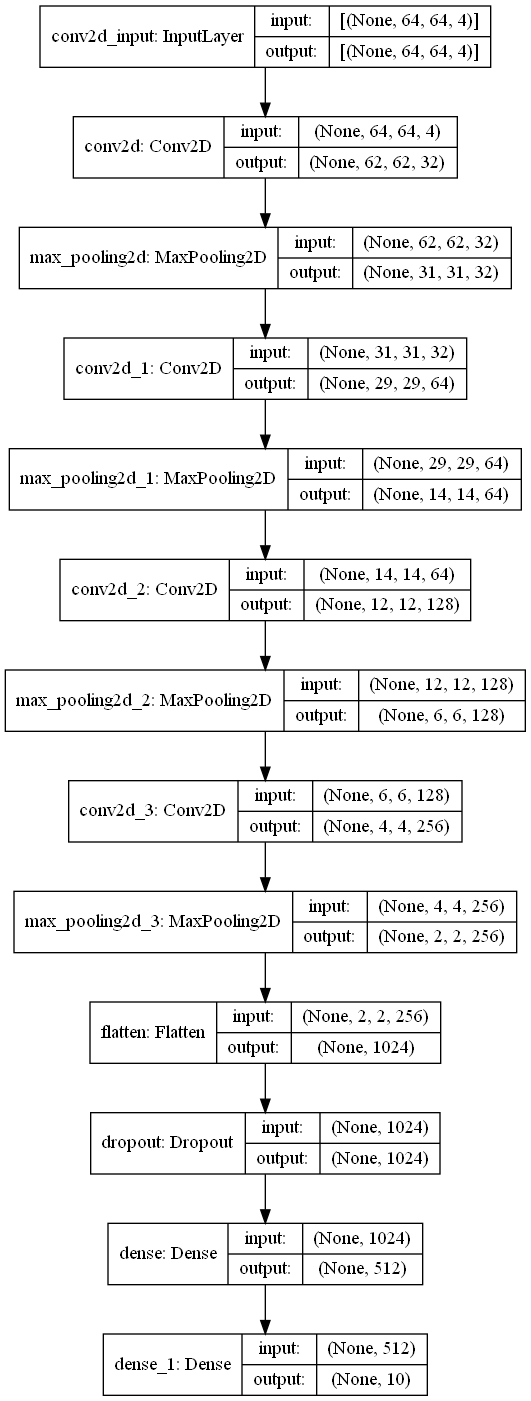

In [34]:
# visualize model
plot_model(M_MS, show_shapes=True, show_layer_names=True)

In [35]:
# data augmentation (adds more training data by randomly transforming images)
train_datagen = ImageDataGenerator(
    shear_range=0.2, # image will be distorted along an axis, to create perception angles
    zoom_range=0.2,
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen = ImageDataGenerator()

In [36]:
batch_size = 64 # number of samples per one model run
epochs = 100 # how many times you go through your training set

# generates batches of augmented data
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size = batch_size,
    seed = 42
)

test_generator = test_datagen.flow(
    X_test,
    y_test,
    batch_size = batch_size,
    seed = 42
)

In [37]:
## takes a while to run!

## fit model to training data
# print learning rate & accuracy at each epoch
history = M_MS.fit_generator(train_generator,
                 steps_per_epoch = len(X_train) // batch_size, # start of new epoch (when one training batch is over)
                 epochs = epochs,
                 validation_data = test_generator,
                 validation_steps = len(X_test) // batch_size,
                 callbacks = callback_list)

C:\Users\carob\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
109/109 [==============================] - 225s 2s/step - loss: 1.5881 - accuracy: 0.3901 - lr: 0.0010 - val_loss: 1.1360 - val_accuracy: 0.5649 - val_lr: 1.0000e-03
Epoch 2/100
109/109 [==============================] - 35s 325ms/step - loss: 1.1556 - accuracy: 0.5561 - lr: 0.0010 - val_loss: 0.8862 - val_accuracy: 0.6637 - val_lr: 1.0000e-03
Epoch 3/100
109/109 [==============================] - 31s 287ms/step - loss: 0.9714 - accuracy: 0.6365 - lr: 0.0010 - val_loss: 0.7050 - val_accuracy: 0.7415 - val_lr: 1.0000e-03
Epoch 4/100
109/109 [==============================] - 32s 292ms/step - loss: 0.8623 - accuracy: 0.6843 - lr: 0.0010 - val_loss: 0.7362 - val_accuracy: 0.7249 - val_lr: 1.0000e-03
Epoch 5/100
109/109 [==============================] - 32s 292ms/step - loss: 0.7789 - accuracy: 0.7157 - lr: 0.0010 - val_loss: 0.8092 - val_accuracy: 0.7103 - val_lr: 1.0000e-03
Epoch 6/100
109/109 [==============================] - 31s 283ms/step - loss: 0.7099 - accuracy: 0.740

In [ ]:
#### 4. Accuracy Assessment ####

In [39]:
# assess model accuracy on test data
score = M_MS.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.26201459765434265
Test accuracy: 0.9146666526794434


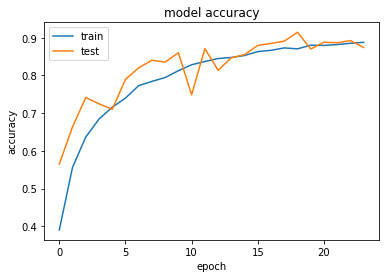

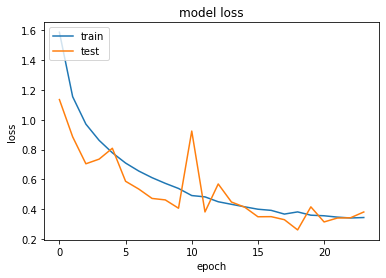

In [40]:
# plot accuracy & loss over time (over epochs of model run)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
# check labeling error of each class
results = M_MS.predict(X_test)

y_pred = np.argmax(results,axis=1) # argmax returns the index of the max value (with the highest class probability)
y_test1 = np.argmax(y_test,axis=1)

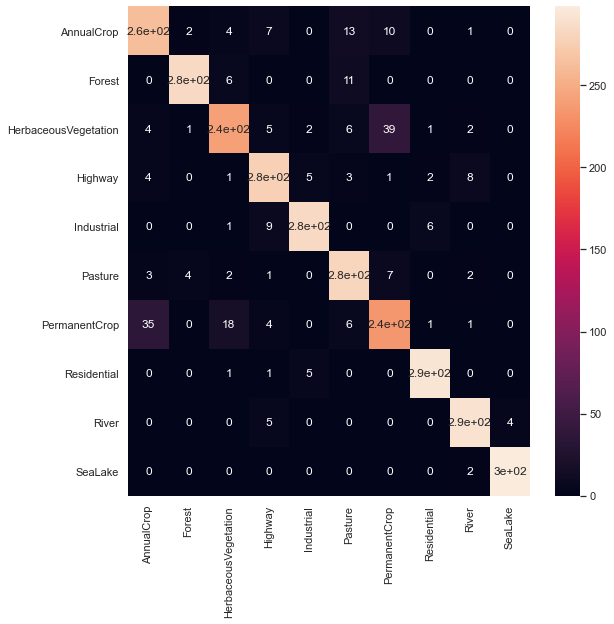

In [44]:
## plot confusion matrix

array = confusion_matrix(y_test1, y_pred)

df_cm = pd.DataFrame(array, range(10), range(10))

plt.figure(figsize=(9,9))
sn.set(font_scale=1) # for label size

x_axis_labels = labels[0:10] # labels for x-axis
y_axis_labels = labels[0:10] # labels for y-axis
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, xticklabels=x_axis_labels, yticklabels=y_axis_labels) # font size

plt.show()

In [ ]:
#### 5. Transfer Learning ####
## Transfer Learning - apply pre-trained model to new dataset (Sentinel-2 tiles (64x64m) for the city of Leipzig in summer 2021)
## validate LULC predictions with in-situ data collected in Leipzig in summer 2021

In [45]:
## read in new validation data
valdir = "Python_FinalProject\\tiles"
vallabels = os.listdir(valdir)

valfiles = [] 

# keep only those containing ".tif"
for file in glob.glob(valdir + os.sep + "*" + os.sep + "*.tif"): # tif.aux files aren't read in!
  valfiles.append(file)

In [46]:
# return array of certain shape with just zeros of size: 64 x 64 pixels, 4 bands
val_images = np.zeros([len(valfiles), 64, 64, 4], dtype="float32")

# Read multi-spectral images as 64x64x4 numpy arrays
i = 0
for pic in valfiles:
  with rasterio.open(pic) as img:
    tmp = np.moveaxis(img.read((1,2,3,4)), 0, 2) # read only 10m bands
    val_images[i] = normalizeBand(tmp)
    i += 1

In [47]:
# create array with labels

val_labs = np.empty(len(valfiles), dtype = 'S20')
i = 0
for label in valfiles:
  val_labs[i] = label.split('\\')[-2]
  i += 1
    
# transfer label names into LULC classes (integer numbers)
val_label_names, val_yLabels = np.unique(val_labs, return_inverse=True)

val_label_Dict = dict(zip(np.unique(val_yLabels), val_label_names))

val_smallest_class = np.argmin(np.bincount(val_yLabels))

# number of classes
val_num_classes = len(np.array(np.unique(yLabels)))

# observations in smallest class
val_smallest_class_obs = np.where(val_yLabels == val_smallest_class)[0] # ~2000

In [48]:
# predict LULC classes of unlabeled data for leipzig

val_pred = M_MS.predict(val_images)
y_val_pred = np.argmax(val_pred,axis=1) # argmax returns the index of the max value per column # as axis 0 = rows, axis 1 = columns

This was labelled as AnnualCrop


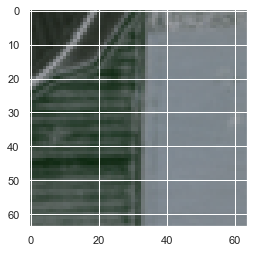

In [49]:
# plot first image & predicted class label
print("This was labelled as " + str(labels[y_val_pred[0]]))
plt.imshow(val_images[0])

In [ ]:
#### 6. Validation via ground truth data ####
## validate LULC predictions with in-situ field data (labelled) of Leipzig

In [51]:
# compare predicted labels with validation subset

# copy arrays
y_val_pred_new = y_val_pred
val_yLabels_new = val_yLabels

# subset to in-situ validation data (remove elements in both arrays according to label 10 (unknown) in first array)
index = 0
for index, element in enumerate(val_yLabels):
    if element == 10:
        y_val_pred_new[index] = 10

In [52]:
# remove rows with 10 (=unknown label)
val_yLabels_new = np.delete(val_yLabels_new, np.where(val_yLabels_new == 10))
y_val_pred_new = np.delete(y_val_pred_new, np.where(y_val_pred_new == 10))

In [53]:
# compare arrays element-wise (returns boolean true / false)

compare_arrays = (val_yLabels_new == y_val_pred_new)

In [54]:
# calculate share of true values

compare_arrays.sum()/len(compare_arrays)

0.4625

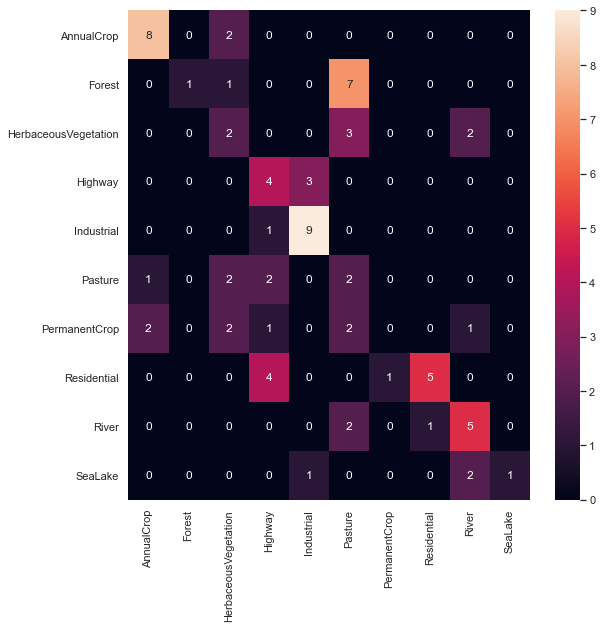

In [55]:
## plot confusion matrix

confmat = confusion_matrix(val_yLabels_new, y_val_pred_new)

df_confmat = pd.DataFrame(confmat, range(10), range(10))

plt.figure(figsize=(9,9))
sn.set(font_scale=1) # for label size

x_axis_labels = labels[0:10] # labels for x-axis
y_axis_labels = labels[0:10] # labels for y-axis
sn.heatmap(df_confmat, annot=True, annot_kws={"size": 12}, xticklabels=x_axis_labels, yticklabels=y_axis_labels) # font size

plt.show()

This was labelled as Pasture
The correct label is Forest


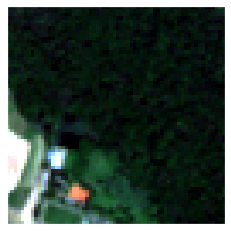

In [56]:
## Plot misclassified image
print("This was labelled as " + str(labels[y_val_pred[13]]))
print("The correct label is " + str(labels[val_yLabels[13]]))

# plot RGB image
raster = rasterio.open(valfiles[13])
img = raster.read((1,2,3,4))

fig, ax = plt.subplots(figsize=(4, 4))

# Plot red, green, and blue bands
ep.plot_rgb(img, rgb = [2, 1, 0], ax=ax, stretch=True)
plt.show()

In [ ]:
#### 7. Research Outcome ####

## high accuracy (> 90 %) of the CNN model applied to the training data
## only ~50% accuracy for field data 
# Class confusion especially in related classes (Annual vs. Permanent Crop, River vs. Lake)
# Forest not identified correctly
# Misclassification of some image tiles could be due to multi-labels in one image (e.g. Residential & Forest, only Residential predicted)

## Advantages of Patch-based classification using Deep Learning on EuroSAT dataset (compared to traditional pixel-based approach)
# Reduced need for in-situ data → only for validation (not for training model)
# Finer differentiation of classes possible, e.g. River vs. lake
# Classification of land use possible, e.g. residential vs. industrial (instead of impervious)
# Includes not only pixels, but also neighborhood around pixels
# Transferability to different areas e.g. other cities in Europe (as EuroSAT dataset based on European Urban Atlas)

## Limitations
# Some classes underrepresented in validation field data patches, e.g. lake
# Multiple classes per patch --> multi-label classification would imporve the accuracy
# Overfitting on training data
# No influence on class definition in training data (EuroSAT)
# Include more bands for higher accuracy in differentiating vegetated classes